In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

from scipy import signal
from scipy.optimize import curve_fit
from scipy import stats
from numpy.polynomial.polynomial import polyval

plt.style.use('seaborn')
%matplotlib inline
sns.set()

In [2]:
def spec_fit(x, c0, c1, c2, c3, w1, w2, f1):
    '''
    A function for fitting peaks to spectra.
    This fit function was copy-pasted in as text from David's fit function on 5/11/21.
    There are two water peaks (free water and bound water) modeled as gaussian peaks w1 and w2.
    There is the f1 fatty acid peak.
    There is a three-term polynomial function.

    :param x: input data
    :param c0: polynomial term 1
    :param c1: polynomial term 2
    :param c2: polynomial term 3
    :param c3: polynomial term 4
    :param w1: water peak term 1
    :param w2: water peak term 2
    :param f1: fatty acid peak
    :return:
    '''

    f_of_x = c0+c1*(x-1700)+c2*(x-1700)**2+c3*(x-1700)**3 + \
             w1*(0.0751747*np.exp(-(x-1903.82)**2/26.4725**2)+0.225213*np.exp(-(x-1942.21)**2/48.8781**2) +
                 0.005*np.exp(-(x-1779.71)**2/32.1869**2))/7.715 + \
             w2*(0.0280945*np.exp(-(x-1913.6)**2/25.0449**2)+0.103527*np.exp(-(x-1949.5)**2/52.2024**2))/3.07 + \
             f1*(0.31*np.exp(-(x-(1730-24))**2/17**2)+np.exp(-(x-1730)**2/17**2)+0.39 *
                 np.exp(-(x-(1730+31))**2/17**2))/25.484
    return f_of_x

def model_fit(df, wave_array):
    '''
    Performs spec_fit function on the input spectra.

    Input parameters:
    df is dataframe containing only the spectra, without extraneous columns
    wave_array is np.array containing the wavelengths of spectra

    Return values:
    modelparams is np.array of parameters output from curve_fit
    modelcovar is np.array of covariance array output from curve_fit
    modeled_spectra is np.array of the modeled spectra using the curve_fit parameters
    residual_spectra is np.array of the original spectrum - the modeled spectrum

    '''
    number = df.shape[0]
    modelparams = np.empty((number, 7), dtype=float)
    modelcovar = np.empty((number, 7, 7), dtype=float)
    modeled_spectra = np.empty((number, wave_array.shape[0]), dtype=float)
    residual_spectra = np.empty((number, wave_array.shape[0]), dtype=float)
    for i in range(number):
        row = df.iloc[i, :]
        modeled, pcov = curve_fit(spec_fit, wave_array, row)
        modelparams[i, :] = modeled
        modelcovar[i, ::] = pcov
        modeled_spectra[i, :] = spec_fit(wave_array, *modeled)
        residual_spectra[i, :] = row - modeled_spectra[i, :]
    return modelparams, modelcovar, modeled_spectra, residual_spectra


def extract_farray(modelparams):
    '''
    Convenience function to create an np.array containing only the f1 values

    Input:  the modelparams np.array created by model_fit().
    '''
    return modelparams[:, 6]


def create_modelparams_df(modelparams):
    columns = ['c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']
    modelparams_df = pd.DataFrame(data=modelparams, columns=columns)
    return modelparams_df


def extract_f_sd_err(modelcovar):
    '''
    Convenience function to create an np.array containing the standard deviation
       of the covariance matrix for the f1 term.

    Input:  the modelcovar np.array created by model_fit().

    '''
    f_sd_err = np.empty(modelcovar.shape[0])
    for i in range(modelcovar.shape[0]):
        f_sd_err[i] = np.diag(modelcovar[i, :, :])[6]
    return f_sd_err


def high_f1_numbers(farray, threshold):
    '''
    Returns np.array of the index positions of spectra with f1 values greater than the
       threshold.  Use this with iloc to find the appropriate rows in the dataframe.

    Input:  np.array output from extract_farray() and desired threshold value.
    '''
    return np.where(farray > threshold)[0]


def get_visible_wavelength_vector(file_path, calibration_path_str):
    with h5py.File(file_path, 'r') as h5_file:
        wavelength_vector = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return wavelength_vector


def get_visible_insertion_absorbance_depth_df(file_path, insertion_path_str):
    with h5py.File(file_path, 'r') as h5_file:
        absorbance_depth = h5_file[f"{insertion_path_str}/derived/absorbance_depth"][:]
        calibration_path_str = insertion_path_str[:17]
        wavelength_vector = h5_file[calibration_path_str].attrs['spec1_wavelengths_vector'][:]
        length = wavelength_vector.shape[0]
        columns = list(np.arange(0, length, 1))
        columns.append('force')
        columns.append('depth')
        dataframe = pd.DataFrame(data=absorbance_depth, columns=columns)
        return dataframe


def create_insertions_date_dataframe(spreadsheet, date_selection):
    df = pd.read_csv(spreadsheet)
    selected_df = df.loc[df['date'] == date_selection]
    return selected_df


In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
spreadsheet = 'data/nirone_misc_insertions_210520.csv'
date_selection = '5/19/21'
f1_threshold = 0.06

selected_date_df = create_insertions_date_dataframe(spreadsheet, date_selection)

high_f1_df = pd.DataFrame()
all_values_df = pd.DataFrame()


for index in selected_date_df.index.unique():

    # Determine variables for getting the appropriate data
    file_name = selected_date_df['file_name'][index]
    file = path_name + file_name
    calibration_path = selected_date_df['session'][index] + '/' + selected_date_df['calibration'][index]
    insertion_path = calibration_path + '/' + selected_date_df['insertion'][index]

    # Get the wavelength vector
    waves = get_visible_wavelength_vector(file, calibration_path)

    # Get the absorbance-force-depth dataset and put in DataFrame format
    try:
        absorbance_depth_df = get_visible_insertion_absorbance_depth_df(file, insertion_path)
        absorbance_depth_df['file_name'] = file_name
        absorbance_depth_df['insertion'] = insertion_path

        # The model input is only the absorbances part of the dataset
        absorbances = absorbance_depth_df.iloc[:, :-4]

        # Run the model
        modelparams, modelcovar, modeled_spectra, residual_spectra = model_fit(absorbances, waves)

        # Calculate the standard deviation of the covariance matrix for the f1 term
        sd_err = extract_f_sd_err(modelcovar)
        absorbance_depth_df['sd_err'] = sd_err

        # RMSE?
        squared_errors = np.square(residual_spectra)
        mse = np.mean(squared_errors, axis=1)
        rmse = np.sqrt(mse)
        absorbance_depth_df['rmse'] = rmse


        # Get the f1 array from the model parameters
        farray = extract_farray(modelparams)
        # absorbance_depth_df['f1_value'] = farray
        absorbance_depth_df[['c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']] = modelparams

        # Determine which of the f1 numbers meet the desired threshold
        ins_high_f1s = high_f1_numbers(farray, f1_threshold)

        # Find the spectra that meet the high f1 threshold
        high_spectra = absorbance_depth_df.iloc[ins_high_f1s, :].copy()

        # Append the spectra to the dataframes
        high_f1_df = pd.concat([high_f1_df, high_spectra], ignore_index=True, sort=False)
        all_values_df = pd.concat([all_values_df, absorbance_depth_df], ignore_index=True, sort=False)

    except:
        print(f"No absorbances for insertion {insertion_path}")

No absorbances for insertion session001/cal001/ins001


In [4]:
all_values_df['f1'].describe()

count    595.000000
mean      -0.083114
std        0.108506
min       -0.778398
25%       -0.132786
50%       -0.104154
75%       -0.045446
max        1.012891
Name: f1, dtype: float64

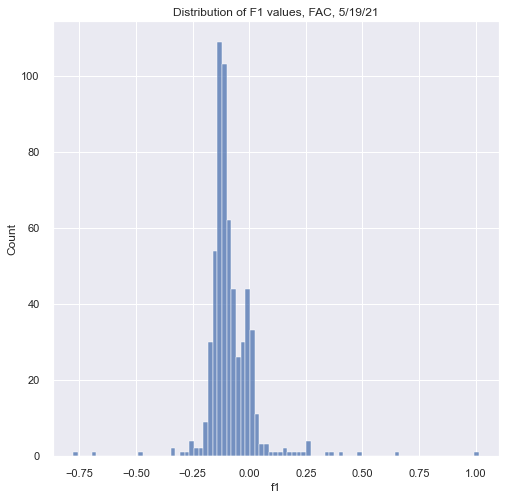

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Distribution of F1 values, FAC, 5/19/21")
sns.histplot(data=all_values_df, x='f1')
plt.show()
plt.close()

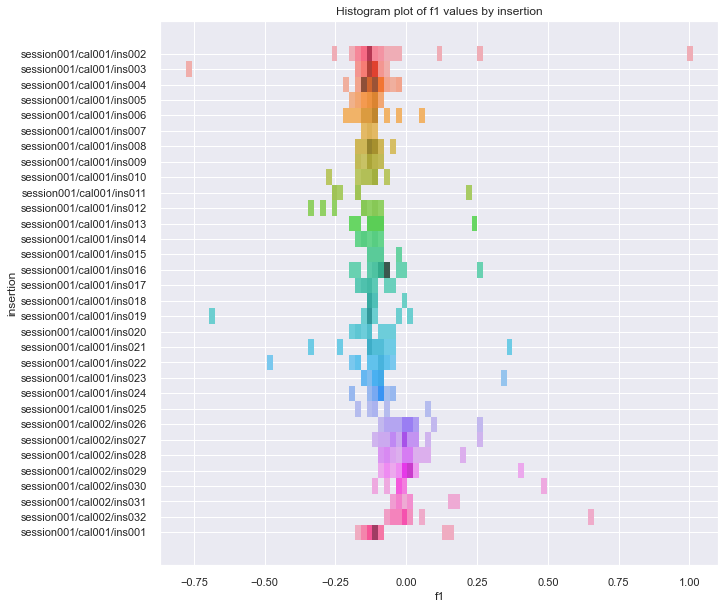

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Histogram plot of f1 values by insertion")
sns.histplot(data=all_values_df, x='f1', y='insertion', hue='insertion', legend=False);
plt.show()
plt.close()

In [7]:
(all_values_df['rmse'] * 100).describe()


count    595.000000
mean       0.165598
std        0.097983
min        0.090997
25%        0.132164
50%        0.146420
75%        0.168490
max        1.538955
Name: rmse, dtype: float64

In [8]:
all_values_df['rmse100'] = all_values_df['rmse']*100


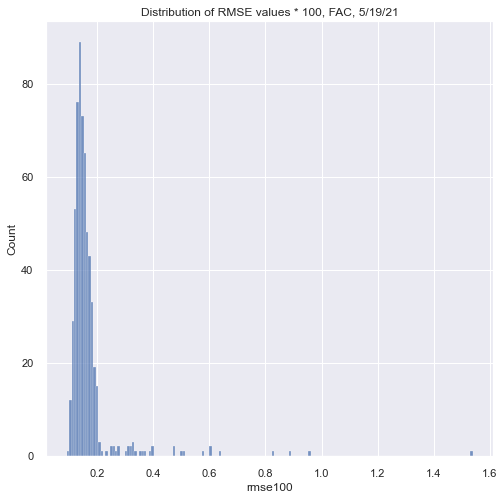

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Distribution of RMSE values * 100, FAC, 5/19/21")
sns.histplot(data=all_values_df, x='rmse100')
plt.show()
plt.close()


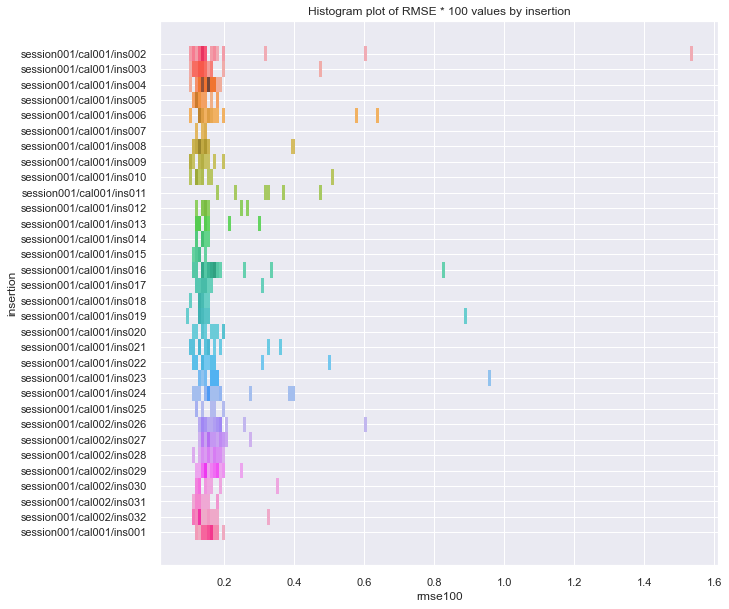

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Histogram plot of RMSE * 100 values by insertion")
sns.histplot(data=all_values_df, x='rmse100', y='insertion', hue='insertion', legend=False);
plt.show()
plt.close()


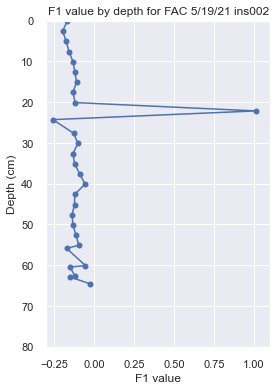

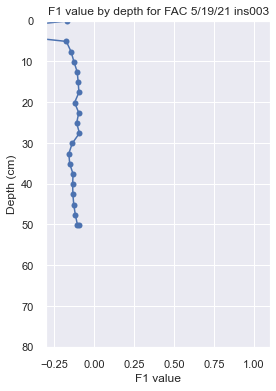

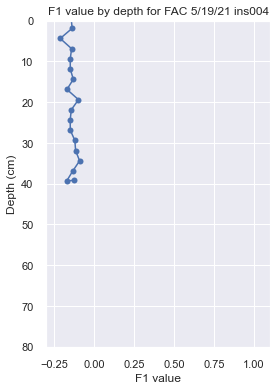

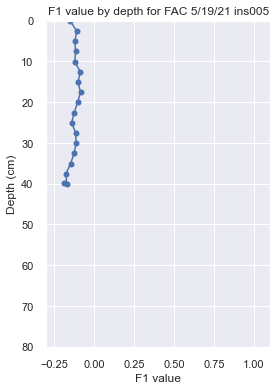

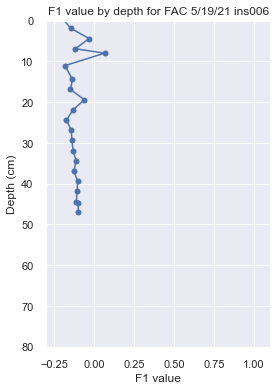

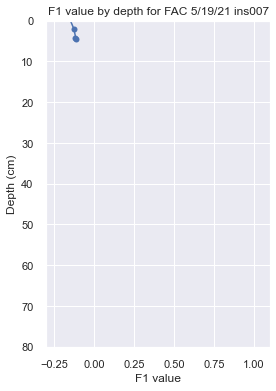

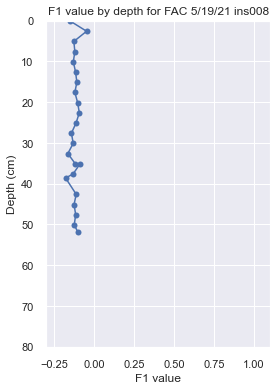

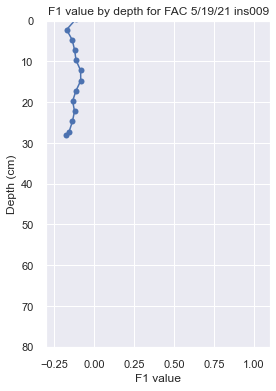

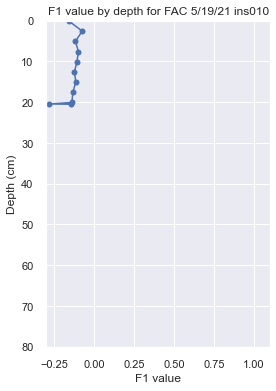

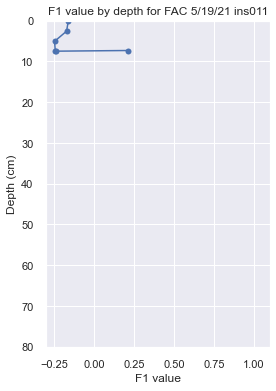

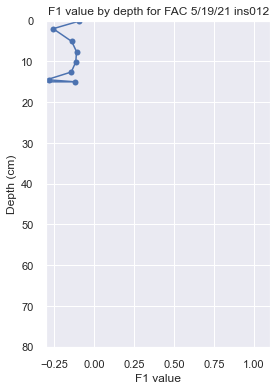

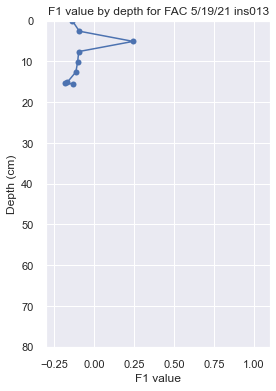

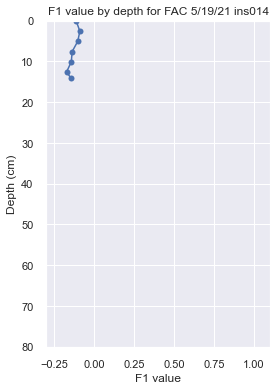

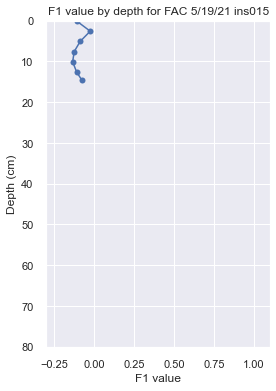

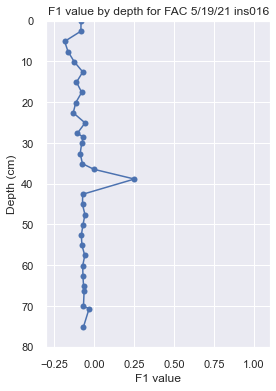

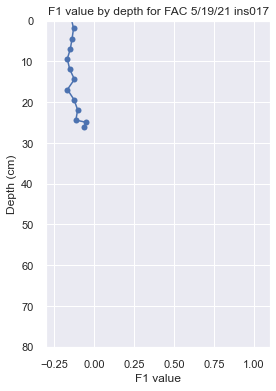

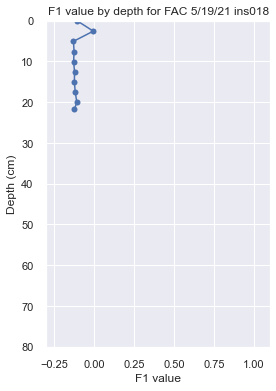

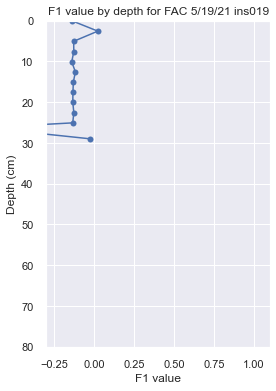

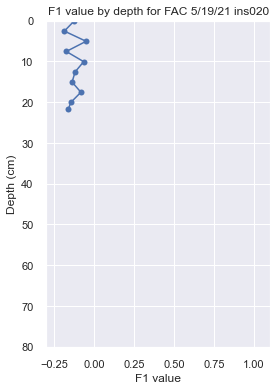

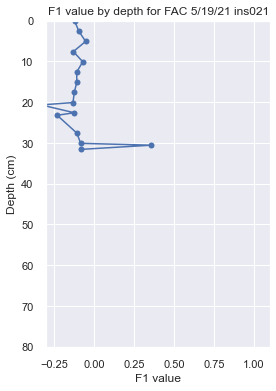

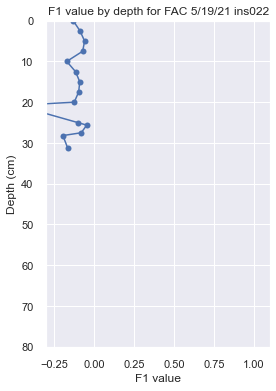

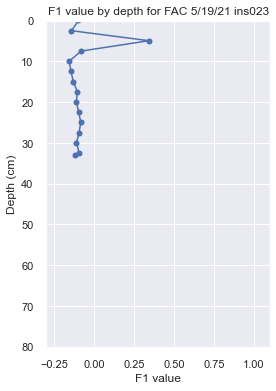

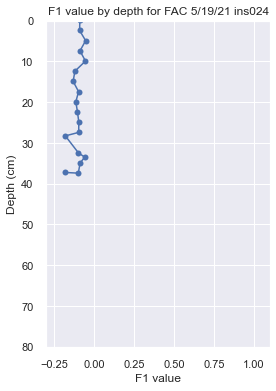

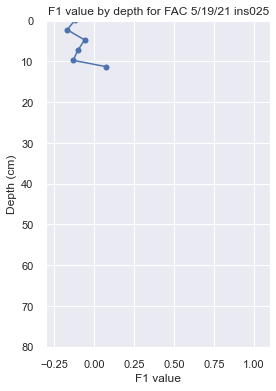

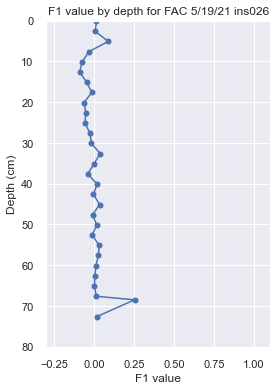

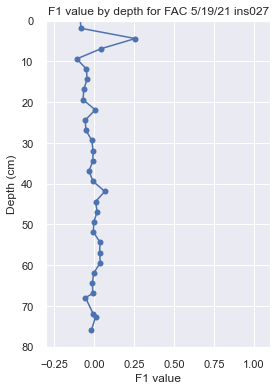

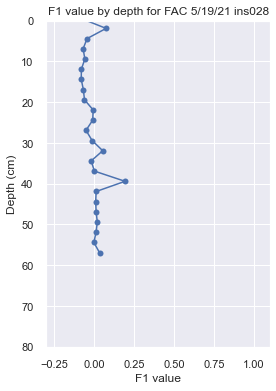

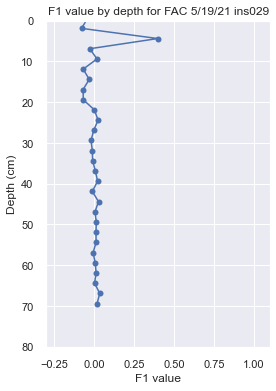

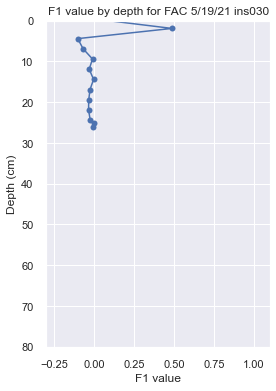

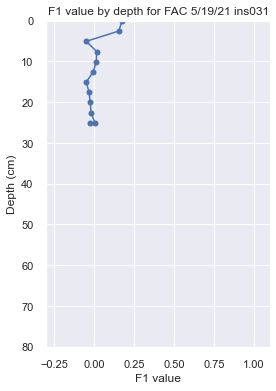

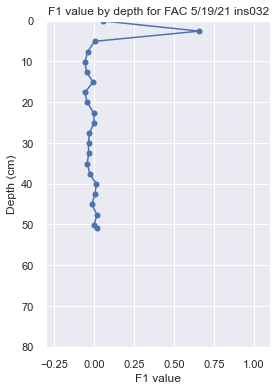

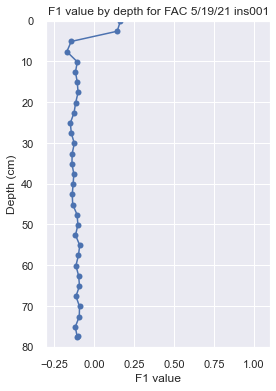

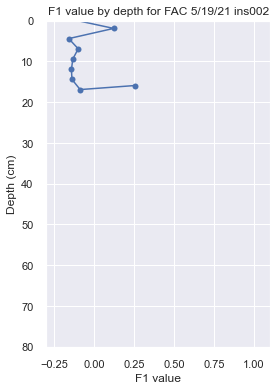

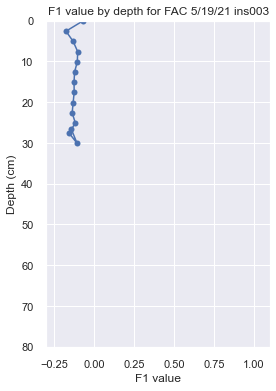

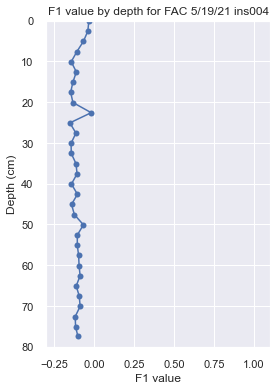

In [11]:
for file_name in all_values_df['file_name'].unique():
    file_df = all_values_df.loc[all_values_df['file_name'] == file_name]
    for insertion in file_df['insertion'].unique():
        plot_df = file_df.loc[file_df['insertion'] == insertion]
        fig, ax = plt.subplots(figsize=(4, 6))
        ax.set_title(f"F1 value by depth for FAC 5/19/21 {insertion[-6:]}")
        ax.set_ylabel("Depth (cm)")
        ax.set_xlabel("F1 value")
        ax.set_ylim(80.0, 0.0)
        ax.set_xlim(-0.3, 1.1)
        ax.plot(plot_df['f1'], plot_df['depth'], '-o')
        plt.show()
        plt.close()


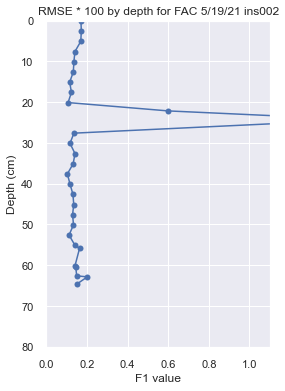

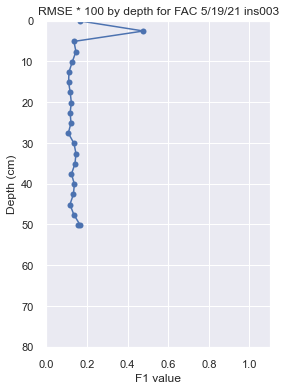

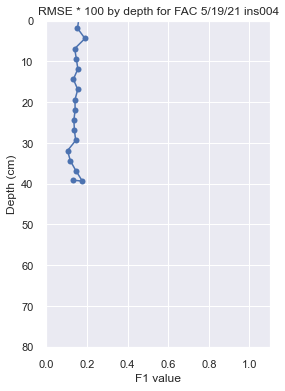

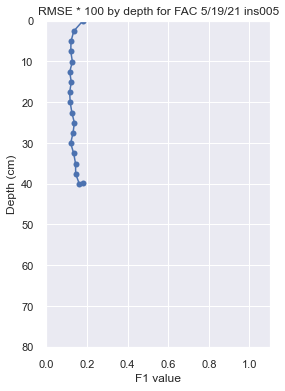

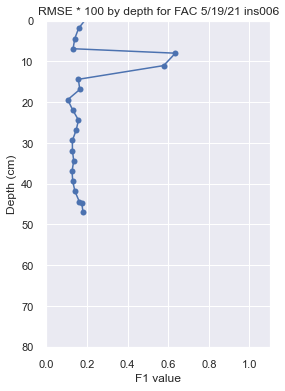

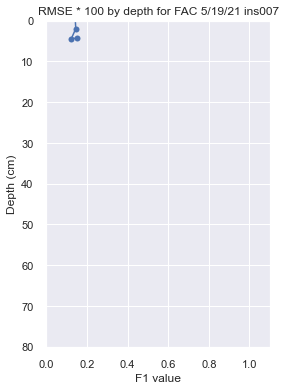

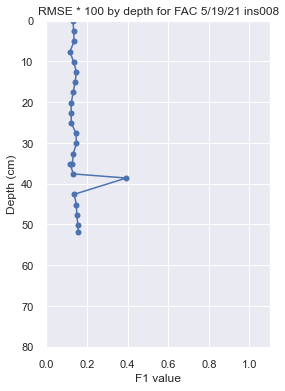

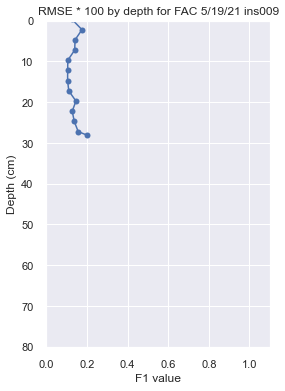

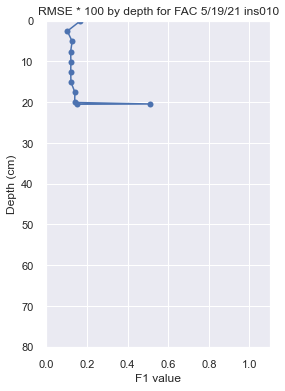

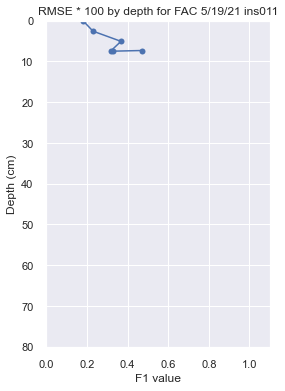

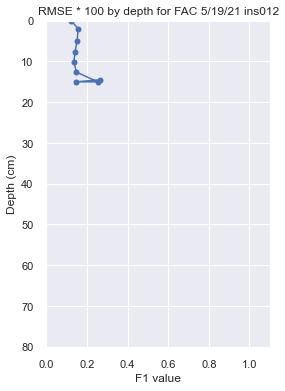

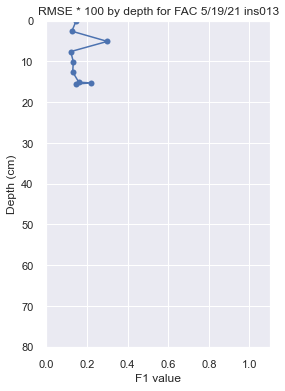

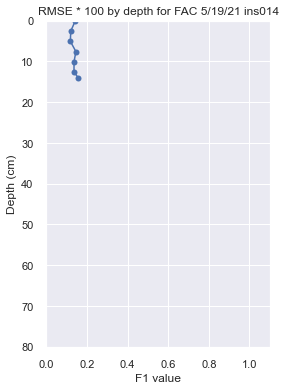

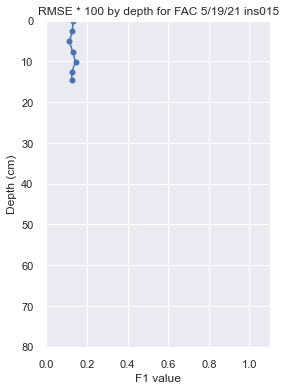

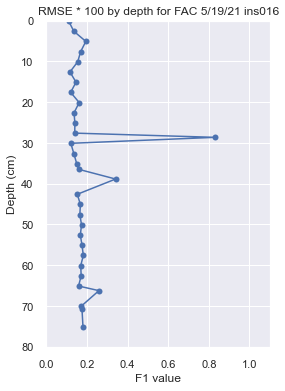

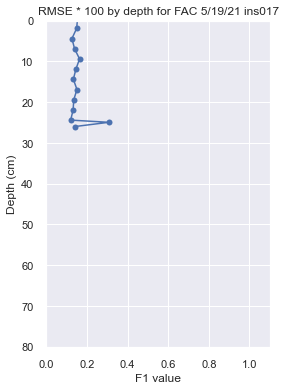

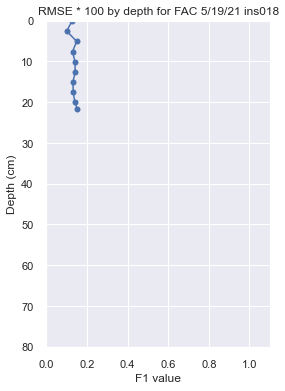

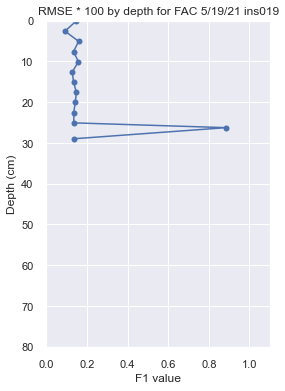

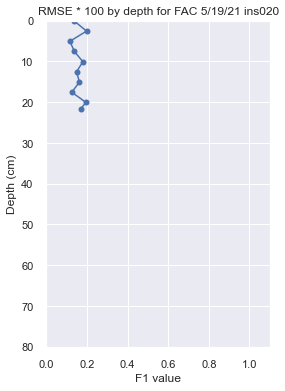

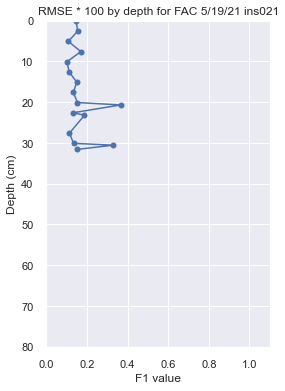

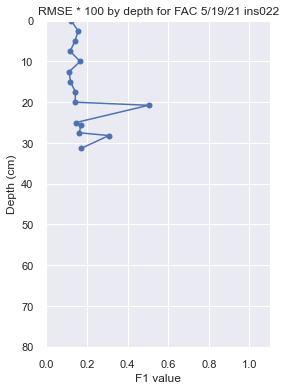

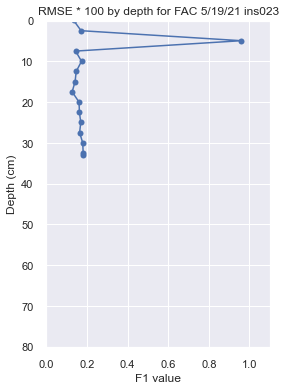

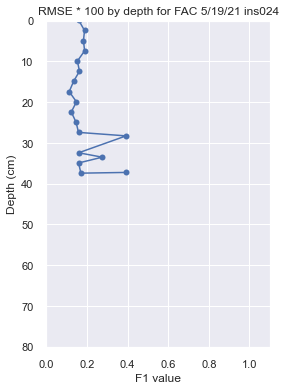

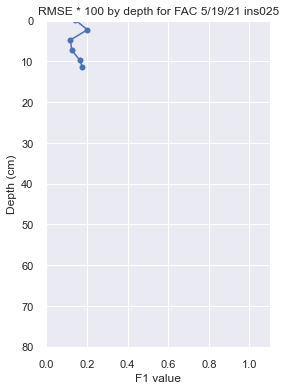

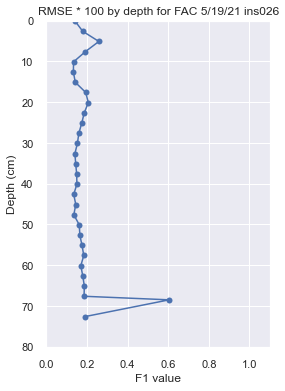

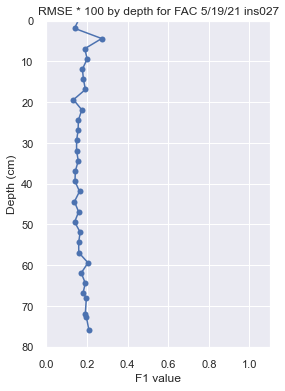

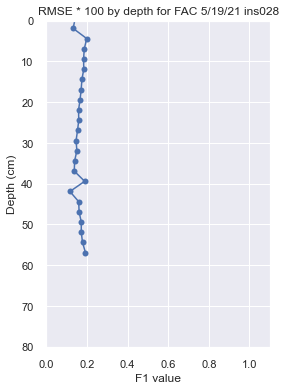

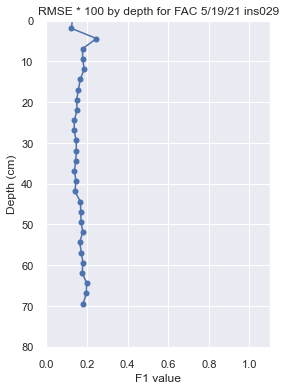

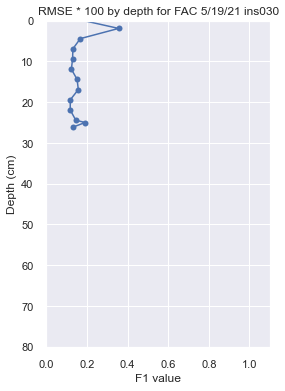

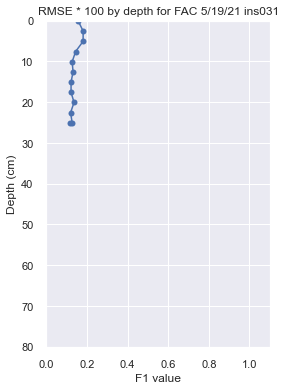

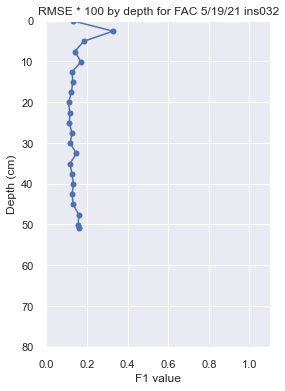

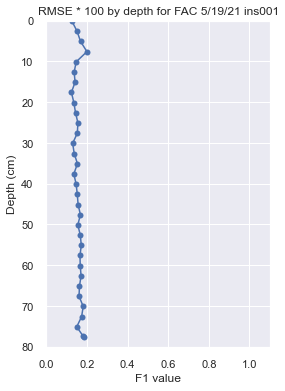

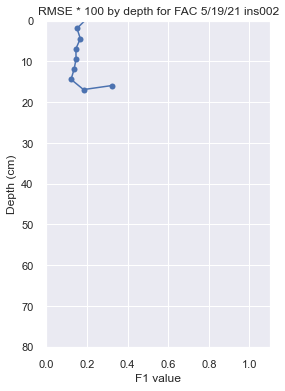

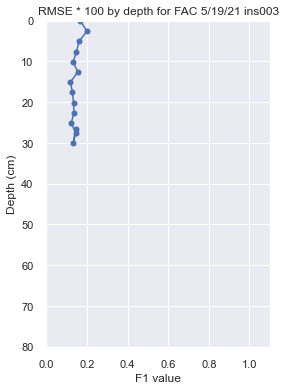

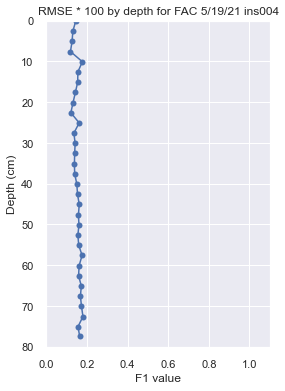

In [12]:
for file_name in all_values_df['file_name'].unique():
    file_df = all_values_df.loc[all_values_df['file_name'] == file_name]
    for insertion in file_df['insertion'].unique():
        plot_df = file_df.loc[file_df['insertion'] == insertion]
        fig, ax = plt.subplots(figsize=(4, 6))
        ax.set_title(f"RMSE * 100 by depth for FAC 5/19/21 {insertion[-6:]}")
        ax.set_ylabel("Depth (cm)")
        ax.set_xlabel("F1 value")
        ax.set_ylim(80.0, 0.0)
        ax.set_xlim(0, 1.1)
        ax.plot(plot_df['rmse100'], plot_df['depth'], '-o')
        plt.show()
        plt.close()

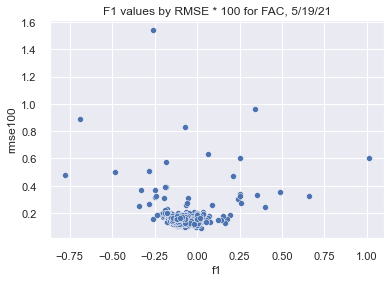

In [14]:
# Looking for a relationship between the F1 values and the error measurements
fig, ax = plt.subplots()
ax.set_title("F1 values by RMSE * 100 for FAC, 5/19/21")
sns.scatterplot(data=all_values_df, x='f1', y='rmse100')
plt.show()
plt.close()

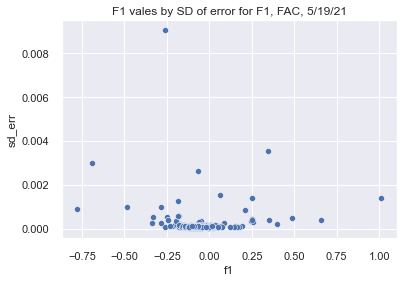

In [15]:
fig, ax = plt.subplots()
ax.set_title("F1 vales by SD of error for F1, FAC, 5/19/21")
sns.scatterplot(data=all_values_df, x='f1', y='sd_err')
plt.show()
plt.close()


In [16]:
# This is a listing of all the samples that met or exceeded the F1 = 0.06 threshold
high_f1_df[['file_name', 'insertion', 'depth']]

,file_name,insertion,depth
0,210519_FAC/FAC_data_collection.h5,session001/cal001/ins002,22.143314
1,210519_FAC/FAC_data_collection.h5,session001/cal001/ins006,7.983778
2,210519_FAC/FAC_data_collection.h5,session001/cal001/ins011,7.324699
3,210519_FAC/FAC_data_collection.h5,session001/cal001/ins013,5.090210
4,210519_FAC/FAC_data_collection.h5,session001/cal001/ins016,38.850671
5,210519_FAC/FAC_data_collection.h5,session001/cal001/ins021,30.552844
6,210519_FAC/FAC_data_collection.h5,session001/cal001/ins023,4.920132
7,210519_FAC/FAC_data_collection.h5,session001/cal001/ins025,11.275517
8,210519_FAC/FAC_data_collection.h5,session001/cal002/ins026,5.105450
9,210519_FAC/FAC_data_collection.h5,session001/cal002/ins026,68.479163
